In [1]:
# Importing all the necessary libraries

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
import os
import scipy

In [2]:
# Function definition for the calculation of Compression ratio

def comp_ratio(im_path,im_comp_path):
    im_size = os.stat(im_path).st_size
    im_comp_size = os.stat(im_comp_path).st_size
    c_ratio = im_size/im_comp_size
    return c_ratio

In [3]:
# Function definition for the calculation of PSNR (in dB)

def PSNR(im,im_comp):
    H,W = im.shape
    orig_s = im.astype('float')
    comp_s = im_comp.astype('float')
    mse = np.sum(np.square(orig_s-comp_s))
    mse = mse/(H*W)
    psnr = np.round(10*np.log10((255**2)/mse),2)
    return psnr   

In [4]:
# Reading the color images from disk, converting them to grayscale and saving them to disk

orig_img_path = "C:\D_drive\IITG\Sem-2\DSP Lab\Mini project\PNG samples\sample2.png"
orig_img = cv2.imread(orig_img_path)
img = cv2.cvtColor(orig_img, cv2.COLOR_RGB2GRAY)
img_path = "C:\D_drive\IITG\Sem-2\DSP Lab\Mini project\PNG samples\sample2_gray.png"
cv2.imwrite(img_path,img)

True

# SVD based Image compression

In [5]:
# Function definition to compress an image using SVD algorithm

def SVD(im,im_comp_path,num_singval_ret):
    im_float = im.astype('float')
    u,s,vh = np.linalg.svd(im_float)
    s = np.diag(s)
    K = num_singval_ret
    out_mat = np.matmul(u[:,:K],np.matmul(s[:K,:K],vh[:K,:]))
    im_comp = out_mat.astype('uint8')
    cv2.imwrite(im_comp_path,im_comp)
    return im_comp

In [6]:
# Obtaining the compressed images using SVD and calculating the performance metrics

exponents = list(range(0,7,1))
num_singvals_ret = [2**i for i in exponents]
metrics_svd = []
for i in range(len(num_singvals_ret)):
    img_comp_path = f'C:\D_drive\IITG\Sem-2\DSP Lab\Mini project\svd\svd_{num_singvals_ret[i]}.jpg'
    img_comp = SVD(img,img_comp_path,num_singvals_ret[i])
    c_r = comp_ratio(img_path,img_comp_path)
    psnr = PSNR(img,img_comp)
    metrics_svd.append((c_r,psnr))

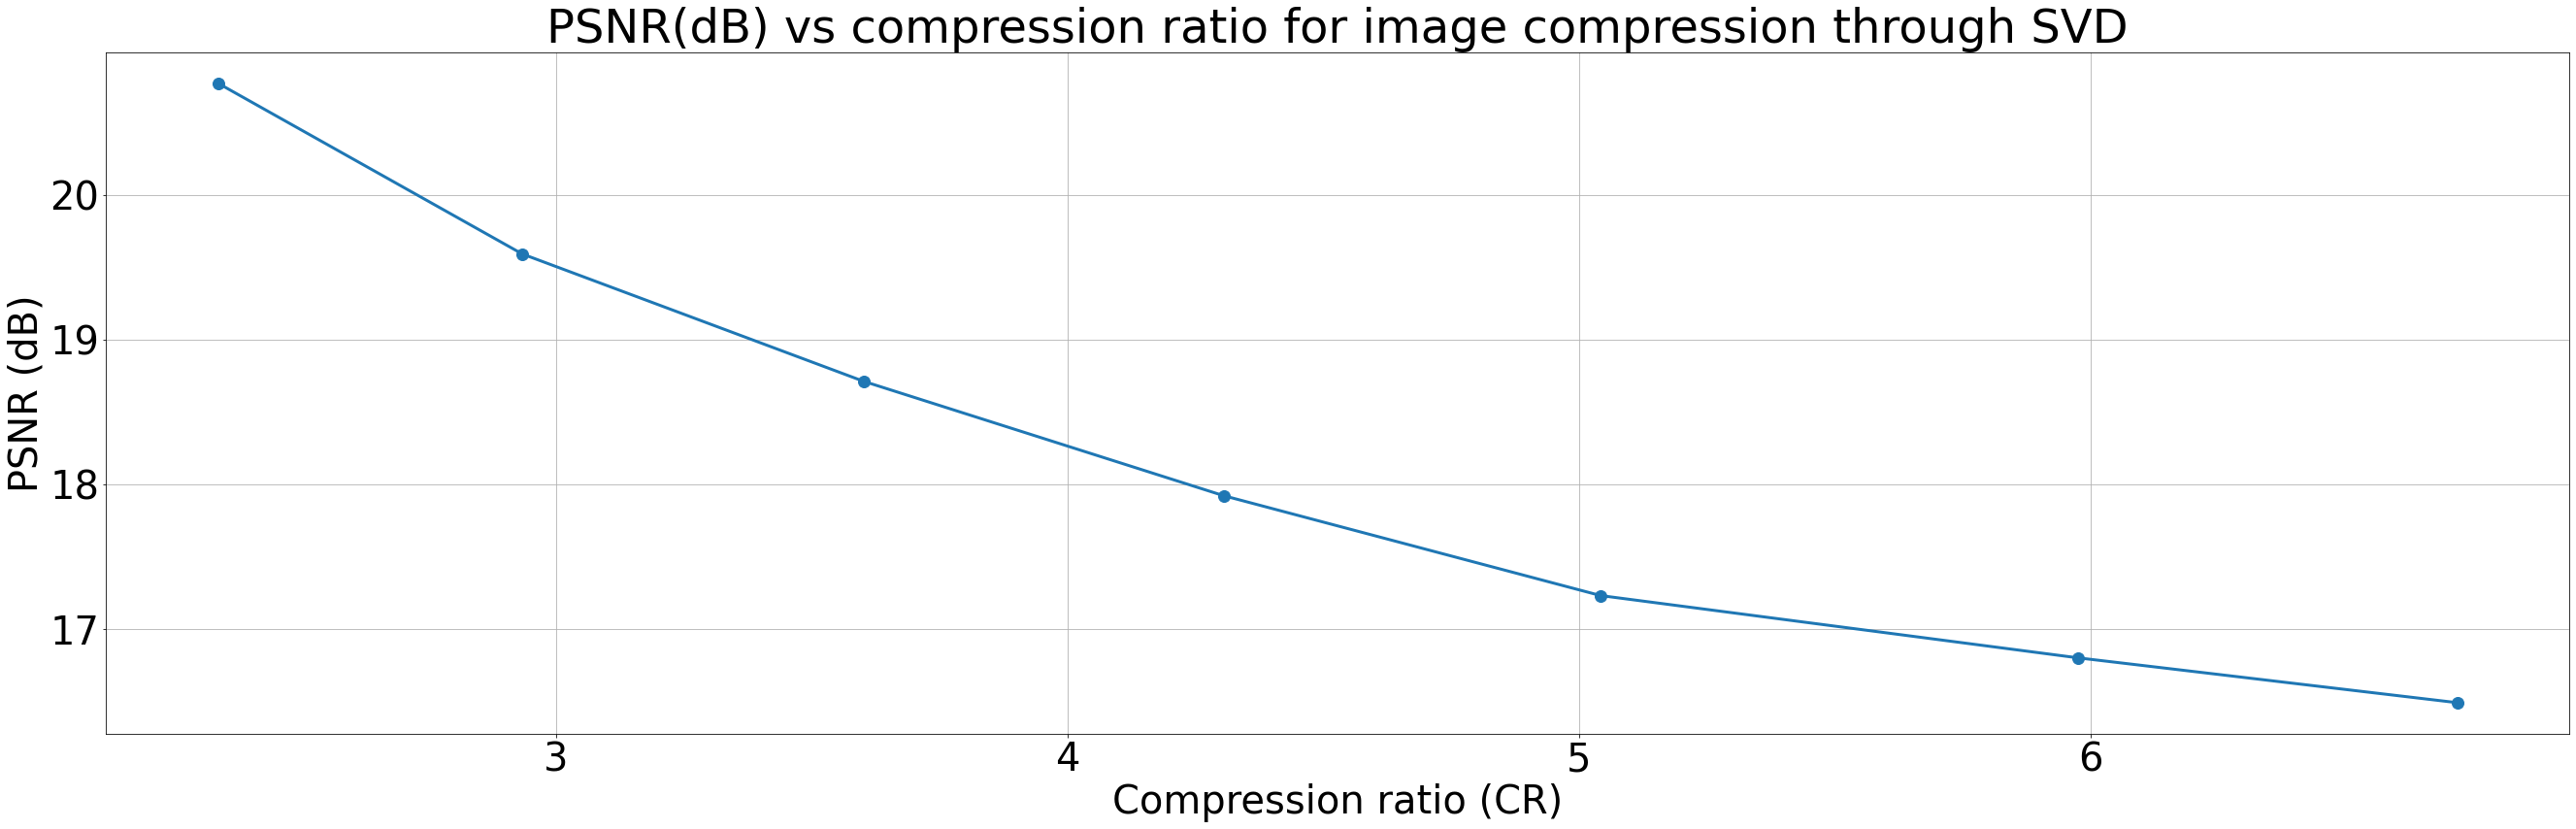

In [7]:
# Plotting the PSNR(in dB) vs Compression Ratio (CR)

values = [[i for i,j in metrics_svd],[j for i,j in metrics_svd]]

matplotlib.rcParams.update({'font.size': 40})
fig,ax = plt.subplots(figsize=(40,15))

ax.plot(values[0],values[1],marker='o',lw=3,ms=12)
ax.set_xlabel('Compression ratio (CR)')
#ax.set_xlim([1,1.4])
ax.set_ylabel('PSNR (dB)')
ax.set_title('PSNR(dB) vs compression ratio for image compression through SVD')
ax.grid()
fig.tight_layout(pad=3.0)

# DCT based Image compression

In [8]:
# Function definition to create quantization matrix. The definition contains the implementation of zig-zag coding

def quantization_matrix(blk_size,num_coeff_ret):
    q_mat = np.zeros((blk_size,blk_size))
    no_ones = num_coeff_ret
    row_ind = 0
    col_ind = 0
    count = 0
    ptr = 0
    while count<no_ones and row_ind+col_ind<=2*blk_size-2:
        if (row_ind==ptr and col_ind==0) or (row_ind==blk_size-1 and col_ind!=0):
            while row_ind+col_ind<=ptr and col_ind<=ptr and row_ind>=0 and count<no_ones:
                q_mat[row_ind,col_ind] = 1
                count += 1
                if col_ind<blk_size-1:
                    col_ind+=1
                    if row_ind>0:
                        row_ind-=1
                elif col_ind==row_ind-1:
                    row_ind+=1                    
        elif (col_ind==ptr and row_ind==0) or (col_ind==blk_size-1 and row_ind!=0):
            while row_ind+col_ind<=ptr and row_ind<=ptr and col_ind>=0 and count<no_ones:
                q_mat[row_ind,col_ind] = 1
                count += 1
                if row_ind<blk_size-1:
                    row_ind+=1
                    if col_ind>0: 
                        col_ind-=1
                elif row_ind==blk_size-1:
                    col_ind+=1           
        if ptr<2*blk_size-2:
            ptr+=1
    return q_mat  

In [9]:
# Function definition of DCT compression algorithm

def DCT_comp(im,im_comp_path,blk_size,num_coeff_ret):
    H,W = im.shape
    im_float = im.astype('float')
    dct_mat = np.zeros((H,W))
    dct_quant = np.zeros((H,W))
    im_comp = np.zeros((H,W))
    q_mat = quantization_matrix(blk_size,num_coeff_ret)
    rows_round = (H//blk_size)*blk_size
    cols_round = (W//blk_size)*blk_size
    for r in range(0,rows_round,blk_size):
        for c in range(0,cols_round,blk_size):
            dct_mat[r:r+blk_size,c:c+blk_size] = scipy.fft.dctn(im_float[r:r+blk_size,c:c+blk_size],norm='ortho')
            dct_quant[r:r+blk_size,c:c+blk_size] = dct_mat[r:r+blk_size,c:c+blk_size]*q_mat
            im_comp[r:r+blk_size,c:c+blk_size] = scipy.fft.idctn(dct_quant[r:r+blk_size,c:c+blk_size],norm='ortho')
    im_comp[rows_round:H,cols_round:W] = im_float[rows_round:H,cols_round:W]
    im_comp = im_comp.astype('uint8') 
    cv2.imwrite(im_comp_path,im_comp)
    return im_comp

In [10]:
# Obtaining the compressed images using DCT and calculating the performance metrics

blk_sizes = [8,32]
metrics_dct = []
for p in range(len(blk_sizes)):
    metrics_dct.append([])
for i in range(len(blk_sizes)):
    temp_list = list(range(1,(blk_sizes[i]**2),blk_sizes[i]))
    num_coeffs_ret = [int(k) for k in temp_list]
    dirName = f'C:\D_drive\IITG\Sem-2\DSP Lab\Mini project\dct\size_{blk_sizes[i]}'
    if not os.path.exists(dirName):
        os.mkdir(dirName)
    for j in range(len(num_coeffs_ret)):
        img_comp_path = f'C:\D_drive\IITG\Sem-2\DSP Lab\Mini project\dct\size_{blk_sizes[i]}\dct_{num_coeffs_ret[j]}.jpg'
        img_comp = DCT_comp(img,img_comp_path,blk_sizes[i],num_coeffs_ret[j])
        c_r = comp_ratio(img_path,img_comp_path)
        psnr = PSNR(img,img_comp)
        metrics_dct[i].append((c_r,psnr))

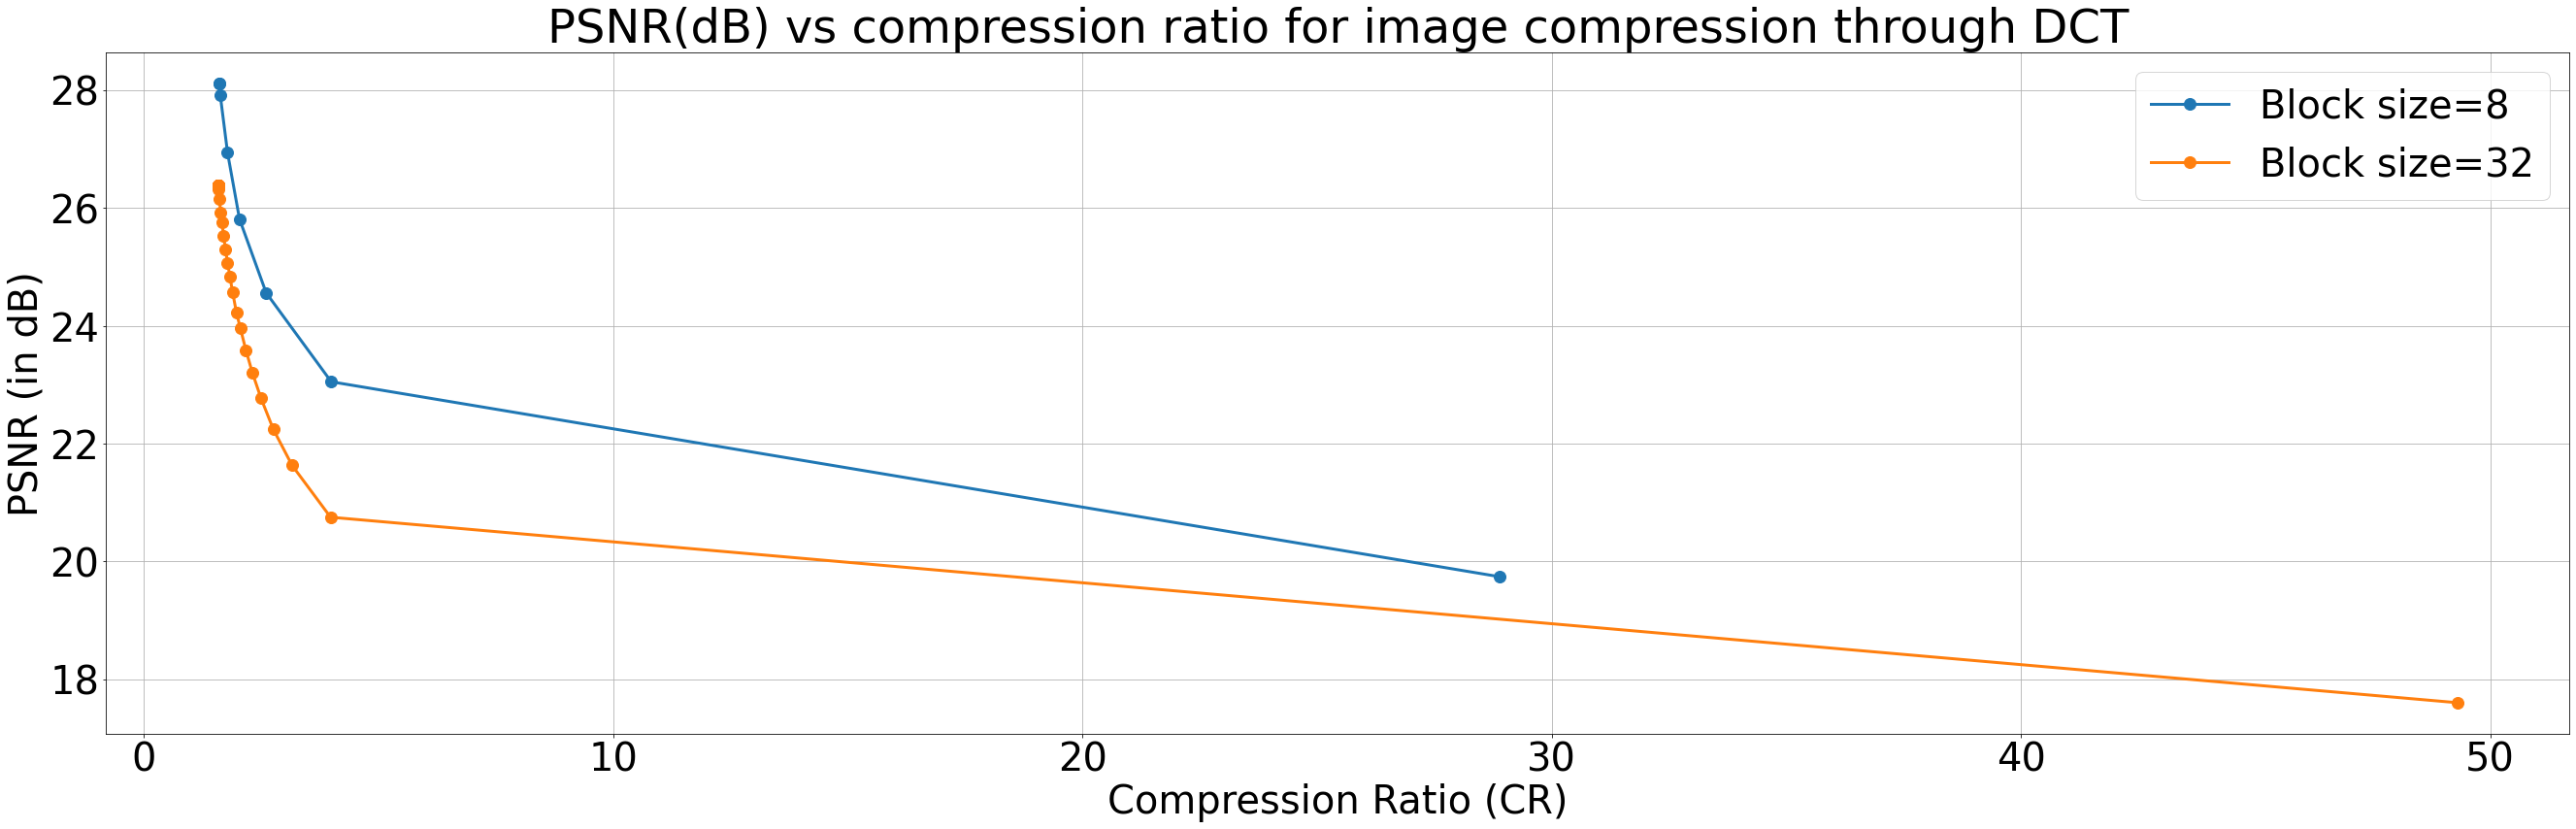

In [11]:
# Plotting the PSNR(in dB) vs Compression Ratio (CR)

matplotlib.rcParams.update({'font.size': 40})
fig,ax = plt.subplots(figsize=(40,15))

for k in range(len(blk_sizes)):
    values = [[i for i,j in metrics_dct[k]],[j for i,j in metrics_dct[k]]]
    ax.plot(values[0],values[1],label=f'Block size={blk_sizes[k]}',marker='o',lw=3,ms=12)
ax.set_xlabel('Compression Ratio (CR)')
#ax.set_xlim([1,2])
ax.set_ylabel('PSNR (in dB)')
ax.set_title('PSNR(dB) vs compression ratio for image compression through DCT')
ax.legend()
ax.grid()
fig.tight_layout(pad=3.0)

# 2D PCA based image compression

In [12]:
# Function definition of 2D PCA image compression algorithm

def PCA_2D_comp(im,im_comp_path,num_singval_ret):
    H,W = im.shape
    im_float = im.astype('float32')
    data_mat_norm = np.zeros((H,W))
    im_comp = np.zeros((H,W))
    data_mat_mean = np.mean(im_float,axis=1)
    for i in range(W):
        data_mat_norm[:,i] = im_float[:,i] - data_mat_mean
    cov_mat = np.cov(im_float,rowvar=True)
    u,s,vh = np.linalg.svd(cov_mat)
    K = num_singval_ret  # K is no of eigen vectors to be retained
    trans_mat = u[:,:K]
    out_mat = np.matmul(trans_mat.T,data_mat_norm)
    im_comp_norm = np.matmul(trans_mat,out_mat)
    for i in range(W):
        im_comp[:,i] = im_comp_norm[:,i] + data_mat_mean
    im_comp = im_comp.astype('uint8')
    cv2.imwrite(im_comp_path,im_comp)
    return im_comp

In [13]:
# Obtaining the compressed images using 2D PCA and calculating the performance metrics

exponents = list(range(0,7,1))
num_singvals_ret = [2**i for i in exponents]
metrics_pca_2d = []
for j in range(len(num_singvals_ret)):
    img_comp_path = f'C:\D_drive\IITG\Sem-2\DSP Lab\Mini project\pca_2d\pca_{num_singvals_ret[j]}.jpg'
    img_comp = PCA_2D_comp(img,img_comp_path,num_singvals_ret[j])
    c_r = comp_ratio(img_path,img_comp_path)
    psnr = PSNR(img,img_comp)
    metrics_pca_2d.append((c_r,psnr))

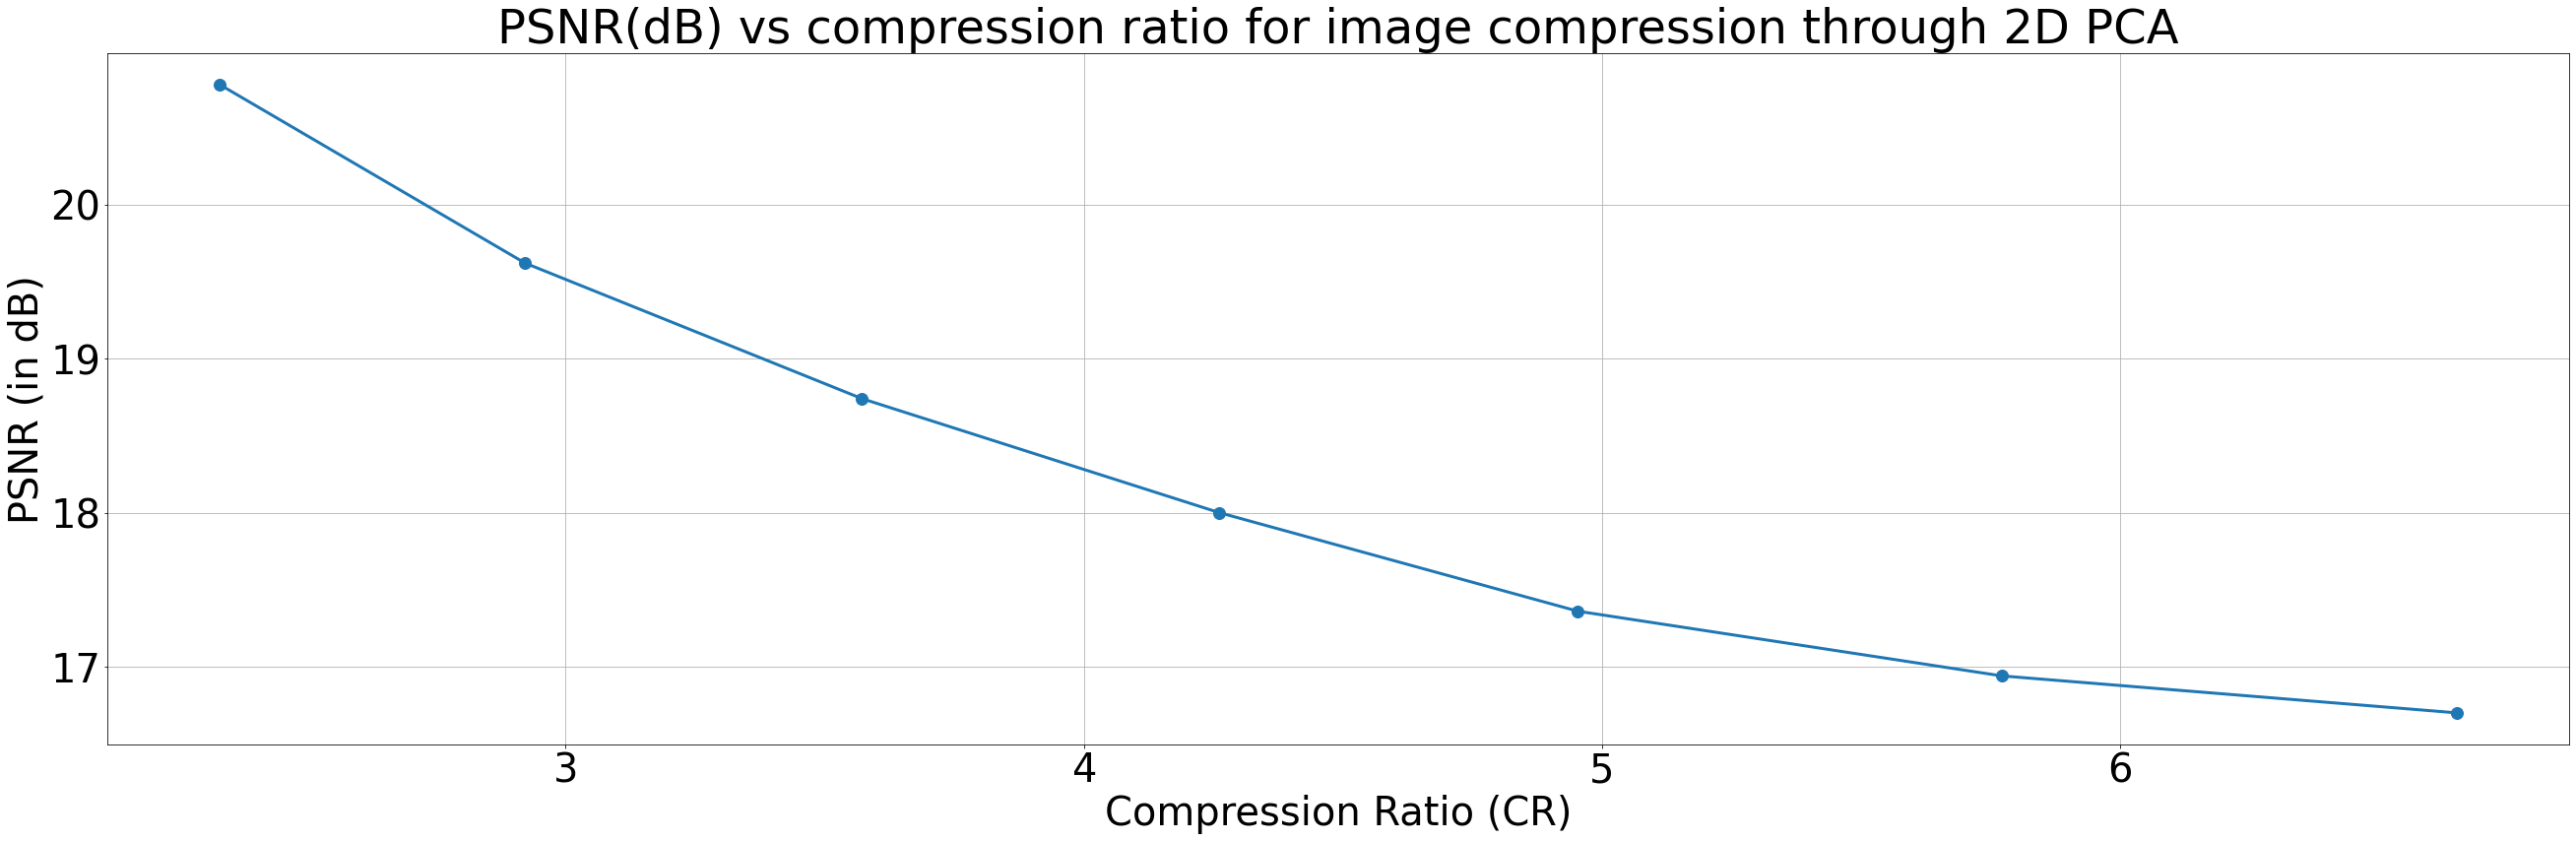

In [14]:
# Plotting the PSNR(in dB) vs Compression Ratio (CR)

matplotlib.rcParams.update({'font.size': 40})
fig,ax = plt.subplots(figsize=(40,15))

values = [[i for i,j in metrics_pca_2d],[j for i,j in metrics_pca_2d]]
ax.plot(values[0],values[1],marker='o',lw=3,ms=12)
ax.set_xlabel('Compression Ratio (CR)')
#ax.set_xlim([1,1.4])
ax.set_ylabel('PSNR (in dB)')
ax.set_title('PSNR(dB) vs compression ratio for image compression through 2D PCA')
ax.grid()
fig.tight_layout(pad=3.0)

# Block-block PCA based image compression

In [15]:
# Function definition of block-block PCA image compression

def PCA_blk_blk_comp(im,im_comp_path,blk_size,num_singval_ret):
    H,W = im.shape
    im_float = im.astype('float')
    im_comp = np.zeros((H,W))
    rows_round = (H//blk_size)*blk_size
    cols_round = (W//blk_size)*blk_size
    for i in range(0,rows_round,blk_size):
        for j in range(0,cols_round,blk_size):
            data_mat = im_float[i:i+blk_size,j:j+blk_size]
            data_mat_norm = np.zeros((blk_size,blk_size))
            im_comp_blk = np.zeros((blk_size,blk_size))
            data_mat_mean = np.mean(data_mat,axis=1)
            for k in range(blk_size):
                data_mat_norm[:,k] = data_mat[:,k] - data_mat_mean
            cov_mat = np.cov(data_mat_norm,rowvar=True)
            u,s,vh = np.linalg.svd(cov_mat)
            #K = int(s.size*perc_ret/100)  # K is no of eigen vectors to be retained
            K = num_singval_ret
            trans_mat = u[:,:K]
            out_mat = np.matmul(trans_mat.T,data_mat_norm)
            im_comp_norm = np.matmul(trans_mat,out_mat)
            for k in range(blk_size):
                im_comp_blk[:,k] = im_comp_norm[:,k] + data_mat_mean
                im_comp[i:i+blk_size,j:j+blk_size] = im_comp_blk
    im_comp[rows_round:H,cols_round:W] = im_float[rows_round:H,cols_round:W]
    im_comp = im_comp.astype('uint8')
    cv2.imwrite(im_comp_path,im_comp)
    return im_comp

In [16]:
# Obtaining the compressed images using 2D block-block PCA and calculating the performance metrics

blk_sizes = [8,32]
metrics_pca_blk_blk = []
for p in range(len(blk_sizes)):
    metrics_pca_blk_blk.append([])
    
for i in range(len(blk_sizes)):
    temp_list = list(range(1,blk_sizes[i],blk_sizes[i]//8))
    num_singvals_ret = [int(k) for k in temp_list]
    dirName = f'C:\D_drive\IITG\Sem-2\DSP Lab\Mini project\pca_blk_blk\size_{blk_sizes[i]}'
    if not os.path.exists(dirName):
        os.mkdir(dirName)
    for j in range(len(num_singvals_ret)):
        img_comp_path = f'C:\D_drive\IITG\Sem-2\DSP Lab\Mini project\pca_blk_blk\size_{blk_sizes[i]}\pca_{num_singvals_ret[j]}.jpg'
        img_comp = PCA_blk_blk_comp(img,img_comp_path,blk_sizes[i],num_singvals_ret[j])
        c_r = comp_ratio(img_path,img_comp_path)
        psnr = PSNR(img,img_comp)
        metrics_pca_blk_blk[i].append((c_r,psnr))

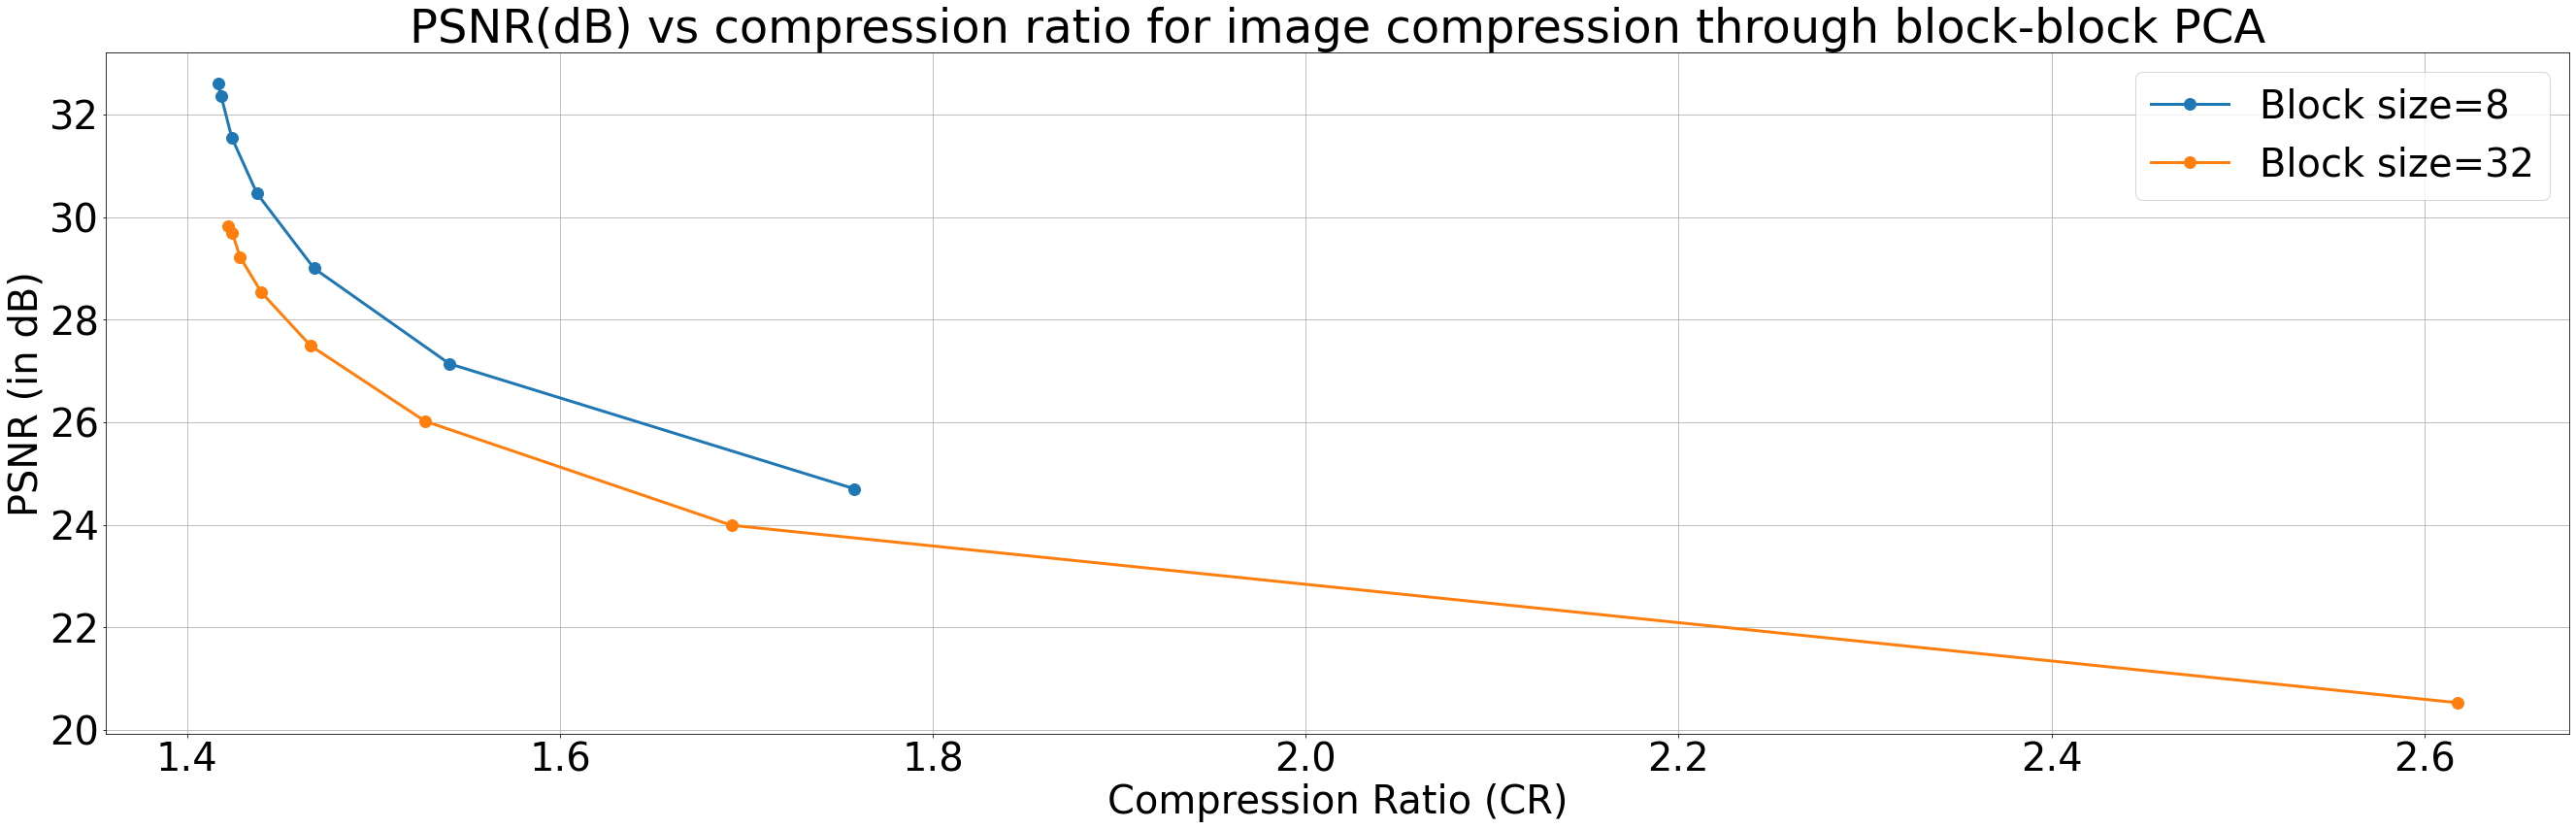

In [17]:
# Plotting the PSNR(in dB) vs Compression Ratio (CR)

matplotlib.rcParams.update({'font.size': 40})
fig,ax = plt.subplots(figsize=(40,15))

for k in range(len(blk_sizes)):
    values = [[i for i,j in metrics_pca_blk_blk[k]],[j for i,j in metrics_pca_blk_blk[k]]]
    ax.plot(values[0],values[1],label=f'Block size={blk_sizes[k]}',marker='o',lw=3,ms=12)
ax.set_xlabel('Compression Ratio (CR)')
#ax.set_xlim([1,1.15])
ax.set_ylabel('PSNR (in dB)')
ax.set_title('PSNR(dB) vs compression ratio for image compression through block-block PCA')
ax.legend()
ax.grid()
fig.tight_layout(pad=3.0)

# Consolidated plot of PSNR vs compression ratio for all algorithms

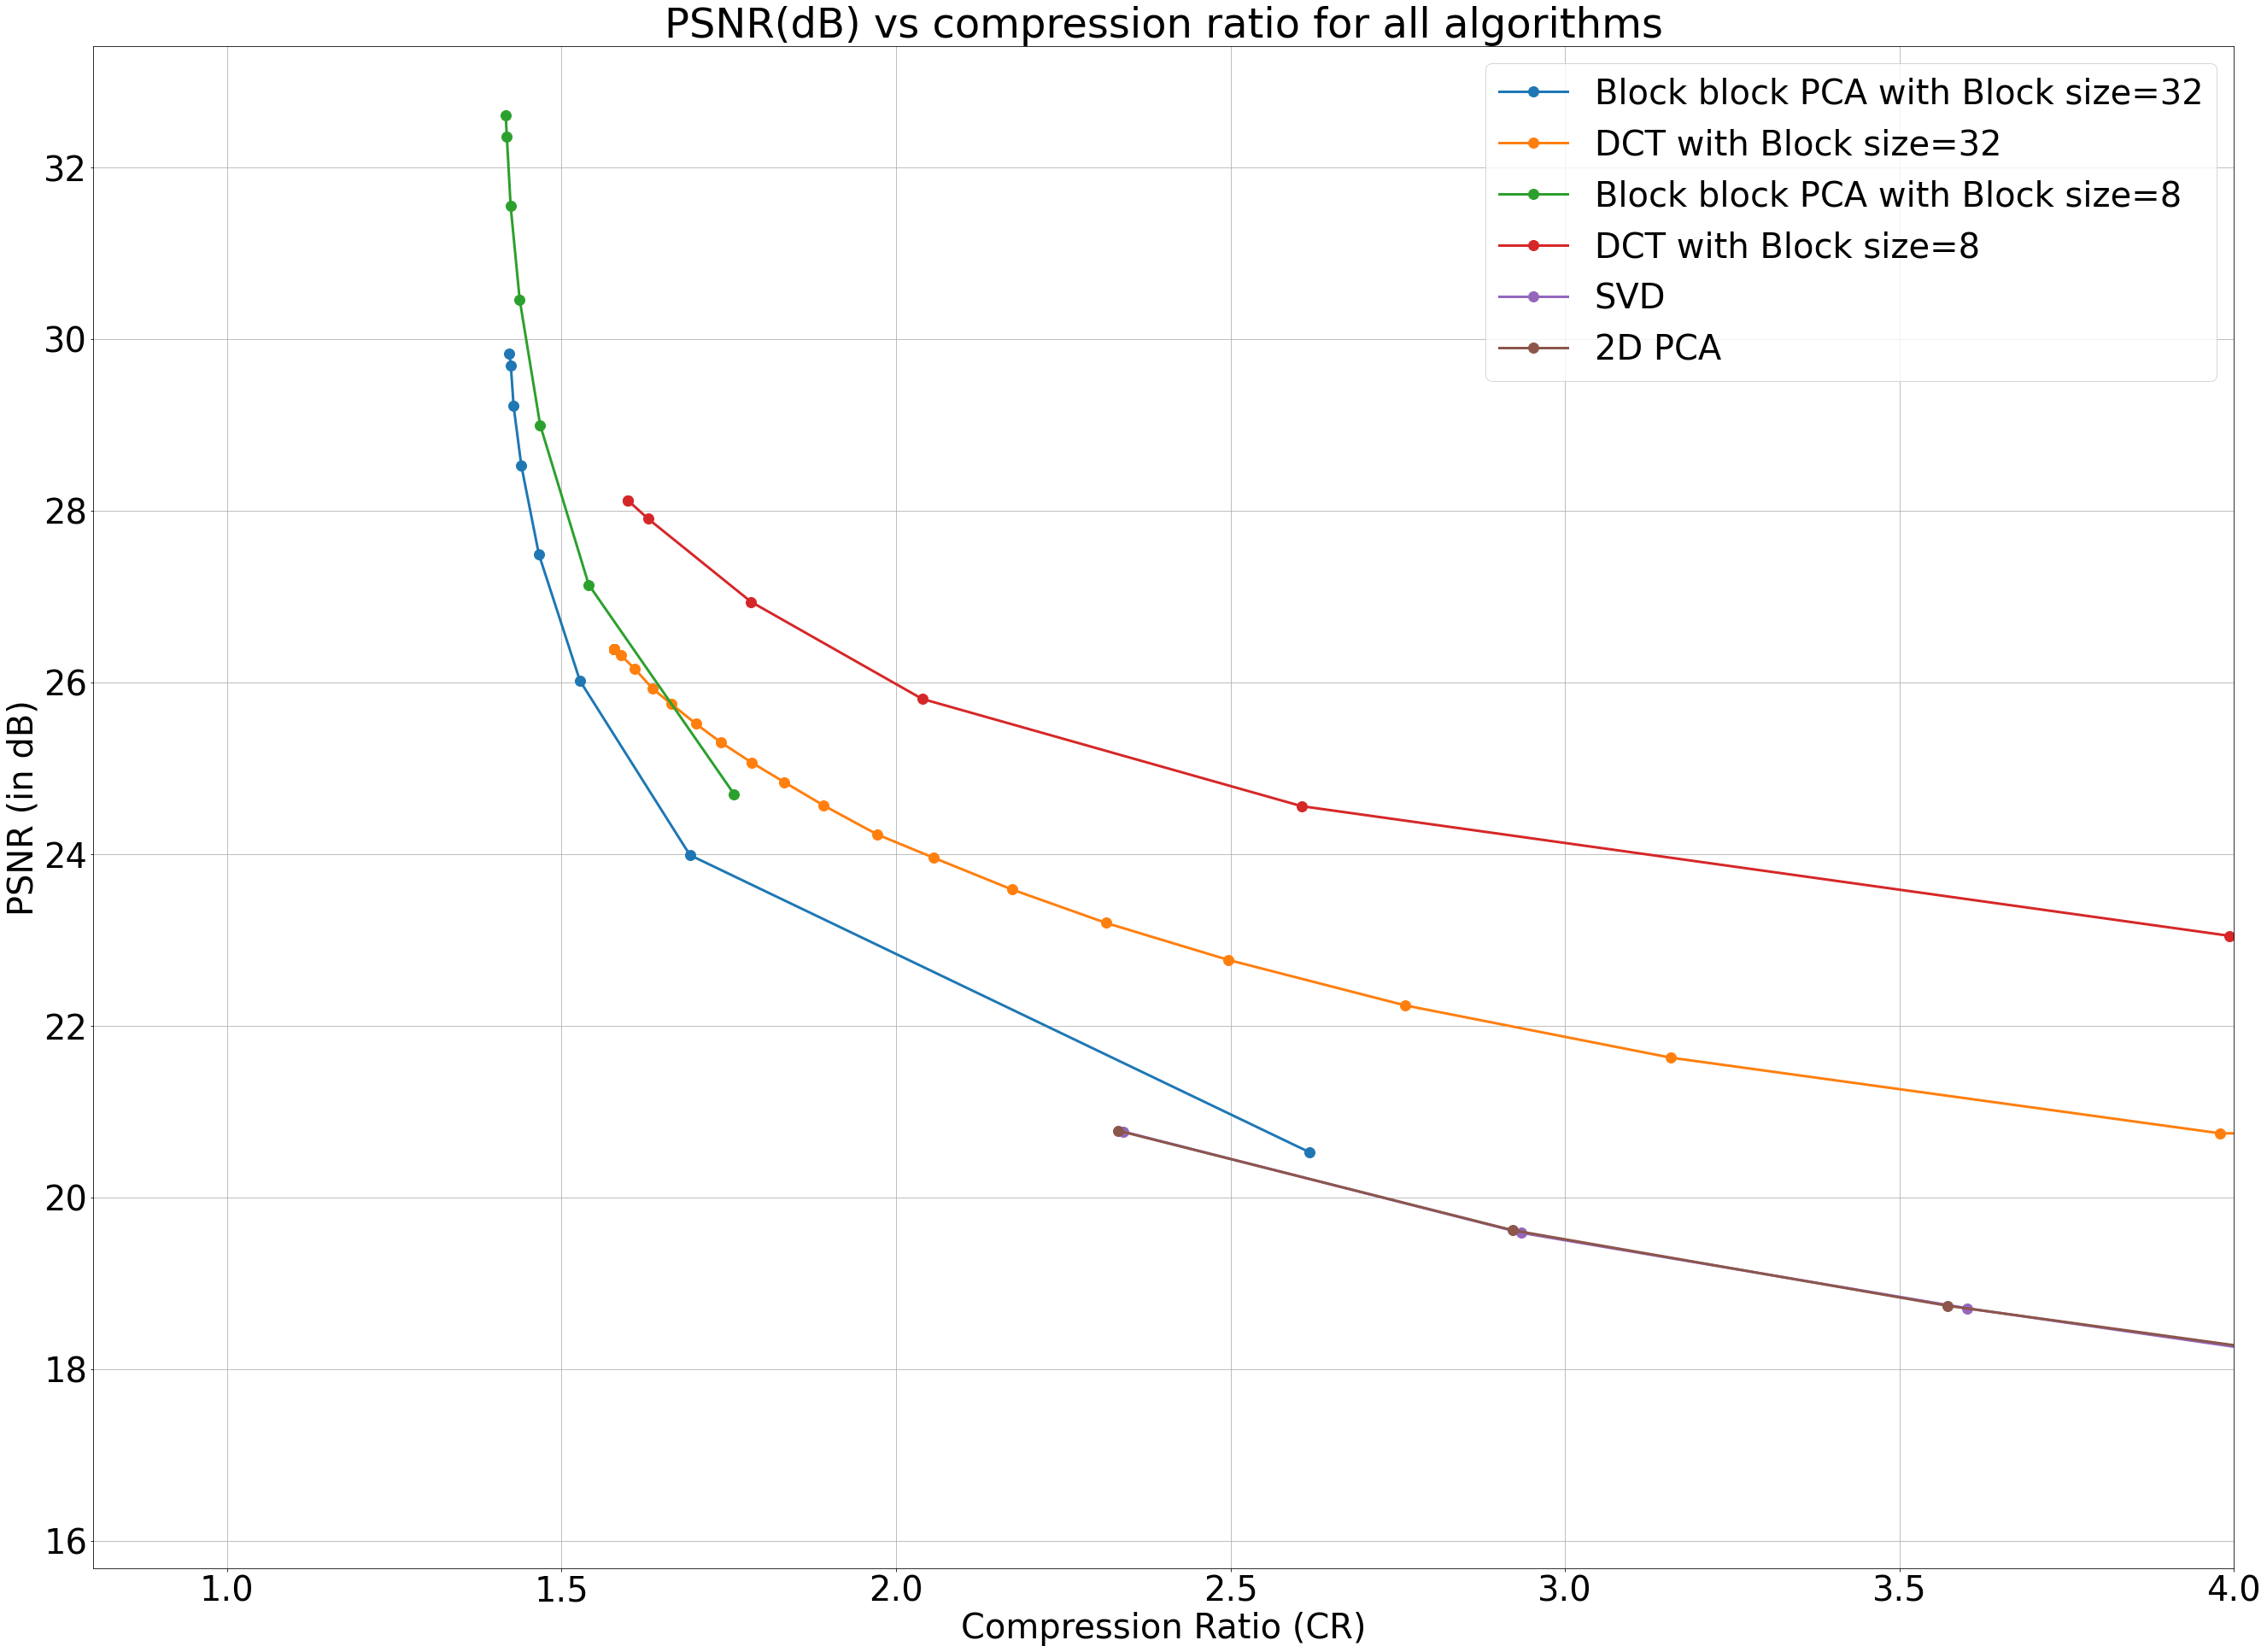

In [18]:
# Plotting the PSNR(in dB) vs Compression Ratio (CR) for all the algorithms used in this project

matplotlib.rcParams.update({'font.size': 40})
fig,ax = plt.subplots(figsize=(40,30))
metrics = [metrics_svd,metrics_dct,metrics_pca_2d,metrics_pca_blk_blk]

for k in range(1,-1,-1):
    values = [[i for i,j in metrics_pca_blk_blk[k]],[j for i,j in metrics_pca_blk_blk[k]]]
    ax.plot(values[0],values[1],label=f'Block block PCA with Block size={blk_sizes[k]}',marker='o',lw=3,ms=12)
    values = [[i for i,j in metrics_dct[k]],[j for i,j in metrics_dct[k]]]
    ax.plot(values[0],values[1],label=f'DCT with Block size={blk_sizes[k]}',marker='o',lw=3,ms=12)
values = [[i for i,j in metrics_svd],[j for i,j in metrics_svd]]
ax.plot(values[0],values[1],label=f'SVD',marker='o',lw=3,ms=12)
values = [[i for i,j in metrics_pca_2d],[j for i,j in metrics_pca_2d]]
ax.plot(values[0],values[1],label=f'2D PCA',marker='o',lw=3,ms=12)
ax.set_xlabel('Compression Ratio (CR)')
ax.set_xlim([0.8,4])
ax.set_ylabel('PSNR (in dB)')
#ax.set_ylim([10,40])
ax.set_title('PSNR(dB) vs compression ratio for all algorithms')
ax.legend()
ax.grid()
fig.tight_layout(pad=3.0)